In [1]:
import pandas as pd
from textblob import TextBlob
import spacy
import nltk

In [2]:
ecommerce_reviews = pd.read_csv('https://raw.githubusercontent.com/fadlia12345/DataMiningCourse/refs/heads/main/NPL_ecommerce_reviews.csv')

In [3]:
ecommerce_reviews.head()

,ReviewID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
hotel_reviews = pd.read_csv('https://raw.githubusercontent.com/fadlia12345/DataMiningCourse/refs/heads/main/NLP_hotel_reviews.csv')

hotel_reviews.head()

,deceptive,hotel,source,ReviewText
0,truthful,conrad,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,TripAdvisor,I asked for a high floor away from the elevato...


# NLP for E-Commerce Reviews

In [5]:
# Fill missing values in the 'Review Text' column with empty strings
ecommerce_reviews['Review Text'] = ecommerce_reviews['Review Text'].fillna("")

# Ensure relevant columns are accessible
relevant_columns = ['Review Text', 'Rating']
if not all(col in ecommerce_reviews.columns for col in relevant_columns):
    print("Missing columns in dataset. Please check the dataset structure.")


In [6]:
from textblob import TextBlob

# Define a function to calculate sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis
ecommerce_reviews['Sentiment Polarity'] = ecommerce_reviews['Review Text'].apply(get_sentiment)

# Label reviews based on polarity
def sentiment_category(polarity):
    if polarity > 0.3:
        return "Positive"
    elif polarity < -0.3:
        return "Negative"
    else:
        return "Neutral"

ecommerce_reviews['Sentiment'] = ecommerce_reviews['Sentiment Polarity'].apply(sentiment_category)

# Display sentiment distribution
print(ecommerce_reviews['Sentiment'].value_counts())


Sentiment
Neutral     15499
Positive     7931
Negative       56
Name: count, dtype: int64


In [7]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocess the text
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

ecommerce_reviews['Cleaned Text'] = ecommerce_reviews['Review Text'].apply(preprocess_text)

# Topic Modeling
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(ecommerce_reviews['Cleaned Text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print(f"Topic {index}:")
        print([feature_names[i] for i in topic.argsort()[-no_top_words:]])

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic 0:
['like', 'xs', 'run', 'try', 'petite', 'large', 'order', 'fit', 'small', 'size']
Topic 1:
['waist', 'love', 'beautiful', 'color', 'skirt', 'fit', 'fabric', 'like', 'look', 'dress']
Topic 2:
['long', 'wash', 'look', 'fit', 'like', 'jean', 'sweater', 'love', 'pant', 'wear']
Topic 3:
['summer', 'comfortable', 'color', 'buy', 'great', 'fit', 'perfect', 'love', 'wear', 'dress']
Topic 4:
['nice', 'soft', 'fit', 'like', 'wear', 'shirt', 'great', 'love', 'color', 'look']


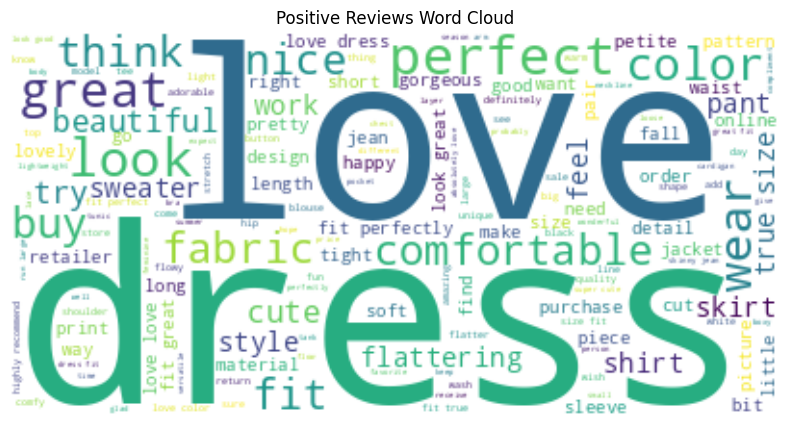

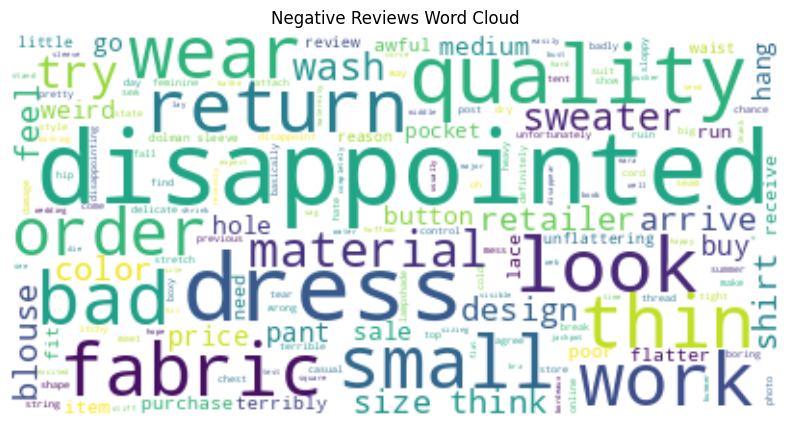

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all positive and negative review text
positive_reviews = " ".join(ecommerce_reviews[ecommerce_reviews['Sentiment'] == "Positive"]['Cleaned Text'])
negative_reviews = " ".join(ecommerce_reviews[ecommerce_reviews['Sentiment'] == "Negative"]['Cleaned Text'])

# Generate word clouds
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews)

# Display word clouds
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()


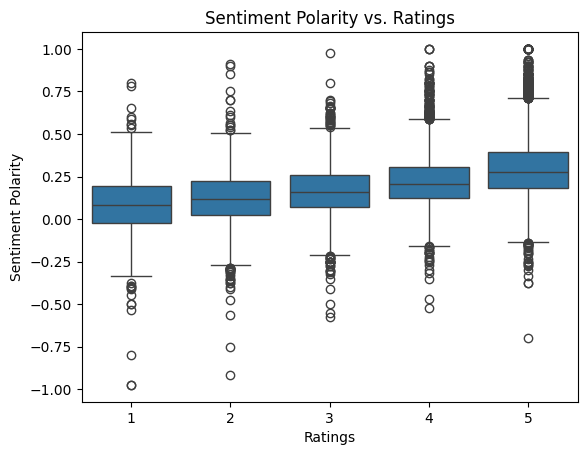

Correlation between Rating and Sentiment Polarity: 0.3531675019400332

Detailed statistics for Sentiment Polarity by Rating (for boxplot):
             min       25%       50%       75%    max
Rating                                               
1      -0.975000 -0.023244  0.083333  0.193006  0.800
2      -0.916667  0.023438  0.118750  0.221726  0.910
3      -0.575000  0.068868  0.161905  0.256786  0.975
4      -0.522321  0.121429  0.208929  0.307500  1.000
5      -0.700000  0.179762  0.278968  0.392393  1.000


In [9]:
import seaborn as sns
import pandas as pd

# Plot sentiment polarity vs rating
sns.boxplot(x='Rating', y='Sentiment Polarity', data=ecommerce_reviews)
plt.title("Sentiment Polarity vs. Ratings")
plt.xlabel("Ratings")
plt.ylabel("Sentiment Polarity")
plt.show()

# Correlation analysis
correlation = ecommerce_reviews[['Rating', 'Sentiment Polarity']].corr()
print("Correlation between Rating and Sentiment Polarity:", correlation.loc['Rating', 'Sentiment Polarity'])

# Add detailed statistics for the boxplot
summary_stats = ecommerce_reviews.groupby('Rating')['Sentiment Polarity'].describe()
print("\nDetailed statistics for Sentiment Polarity by Rating (for boxplot):")
print(summary_stats[['min', '25%', '50%', '75%', 'max']])


# NLP Insights from Hotel Reviews

In [10]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Fill missing values in ReviewText column
hotel_reviews['ReviewText'] = hotel_reviews['ReviewText'].fillna("")

# Step 1: Sentiment Analysis
# Define a function to calculate sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis
hotel_reviews['Sentiment Polarity'] = hotel_reviews['ReviewText'].apply(get_sentiment)

# Categorize reviews as Positive, Neutral, or Negative based on polarity
def sentiment_category(polarity):
    if polarity > 0.3:
        return "Positive"
    elif polarity < -0.3:
        return "Negative"
    else:
        return "Neutral"

hotel_reviews['Sentiment'] = hotel_reviews['Sentiment Polarity'].apply(sentiment_category)

# Display sentiment distribution
print("\nSentiment Distribution:")
print(hotel_reviews['Sentiment'].value_counts())



Sentiment Distribution:
Sentiment
Neutral     1025
Positive     563
Negative      12
Name: count, dtype: int64


In [11]:
from collections import Counter

# Function to extract nouns from text
def extract_nouns(text):
    doc = nlp(text.lower())
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    return nouns

# Apply the function to extract nouns for all reviews
all_nouns = hotel_reviews['ReviewText'].apply(extract_nouns)

# Flatten the list of lists into a single list
flat_nouns = [noun for sublist in all_nouns for noun in sublist]

# Count the frequency of each noun
noun_counts = Counter(flat_nouns)

# Get the top 50 most common nouns
top_50_nouns = noun_counts.most_common(50)

# Display the top 50 nouns
print("Top 50 Nouns:")
for word, count in top_50_nouns:
    print(f"{word}: {count}")



Top 50 Nouns:
hotel: 3123
room: 2812
staff: 836
service: 809
rooms: 679
night: 576
stay: 538
time: 523
desk: 498
location: 481
bed: 457
day: 351
place: 347
bathroom: 341
experience: 326
hotels: 302
business: 293
lobby: 283
view: 273
city: 263
floor: 259
area: 248
food: 245
breakfast: 240
price: 235
weekend: 222
restaurant: 221
bar: 217
trip: 211
beds: 198
husband: 197
minutes: 197
downtown: 192
people: 192
reservation: 192
nights: 190
door: 190
check: 189
morning: 188
way: 187
wife: 182
water: 169
suite: 167
internet: 162
pool: 148
hour: 143
shopping: 140
king: 139
family: 135
guests: 135


In [12]:
# Step 2: Custom Stop Words
# Load spaCy model for preprocessing
nlp = spacy.load("en_core_web_sm")

# Define additional stopwords specific to hotel reviews
custom_stopwords = {
    'hotel', 'room', 'stay', 'night', 'trip', 'staff',
    'service', 'rooms', 'time', 'desk', 'location',
    'bed', 'day', 'place', 'bathroom', 'experience',
    'hotels', 'business', 'lobby', 'view', 'city',
    'floor', 'area', 'food', 'breakfast', 'price',
    'weekend', 'restaurant', 'bar', 'beds', 'husband',
    'minutes', 'downtown', 'people', 'reservation',
    'nights', 'door', 'check', 'morning', 'way',
    'wife', 'water', 'suite', 'internet', 'pool',
    'hour', 'shopping', 'king', 'family', 'chicago', 'guests'
}

# Preprocess the text
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.text not in custom_stopwords
    ]
    return " ".join(tokens)

hotel_reviews['Cleaned Text'] = hotel_reviews['ReviewText'].apply(preprocess_text)


In [13]:
# Step 3: Topic Modeling
# Vectorize the cleaned text
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(hotel_reviews['Cleaned Text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for index, topic in enumerate(model.components_):
        print(f"Topic {index + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]]))

print("\nTopics from Hotel Reviews:")
display_topics(lda, vectorizer.get_feature_names_out(), 10)




Topics from Hotel Reviews:
Topic 1:
tell, nice, wall, clean, hear, pay, look, charge, like, stay
Topic 2:
pay, feel, bad, hilton, work, small, look, stay, good, like
Topic 3:
helpful, comfortable, friendly, nice, clean, michigan, stay, walk, good, great
Topic 4:
clean, say, finally, check, wait, stay, come, arrive, ask, tell
Topic 5:
friendly, feel, recommend, definitely, nice, comfortable, good, like, stay, great


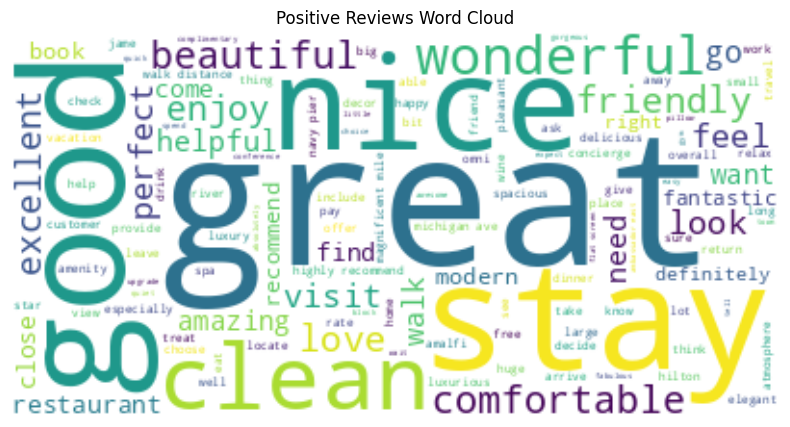

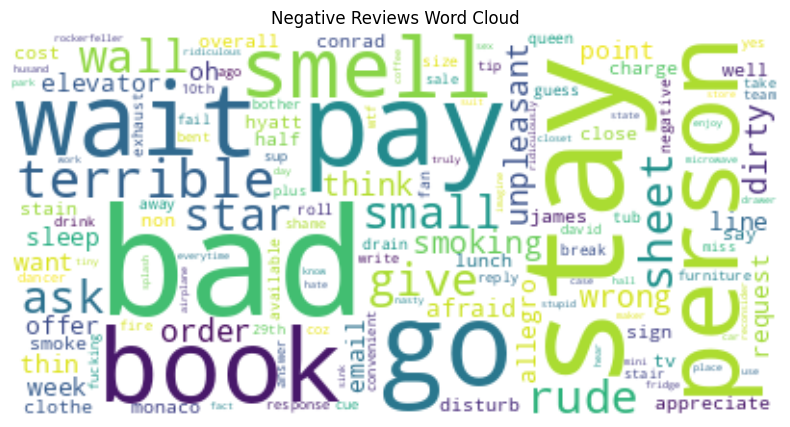

In [14]:
# Step 4: Word Clouds for Positive and Negative Reviews
positive_reviews = " ".join(hotel_reviews[hotel_reviews['Sentiment'] == "Positive"]['Cleaned Text'])
negative_reviews = " ".join(hotel_reviews[hotel_reviews['Sentiment'] == "Negative"]['Cleaned Text'])

# Generate word clouds
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews)

# Display positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

# Display negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()


In [15]:
# Step 1: Re-clean the text with custom stopwords
def preprocess_text_with_stopwords(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.text not in custom_stopwords
    ]
    return " ".join(tokens)

# Apply the updated preprocessing
hotel_reviews['Cleaned Text'] = hotel_reviews['ReviewText'].apply(preprocess_text_with_stopwords)

# Step 2: Recalculate sentiment polarity using the updated cleaned text
def recalculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply the updated sentiment analysis
hotel_reviews['Sentiment Polarity'] = hotel_reviews['Cleaned Text'].apply(recalculate_sentiment)

# Step 3: Update the sentiment category
def updated_sentiment_category(polarity):
    if polarity > 0.3:
        return "Positive"
    elif polarity < -0.3:
        return "Negative"
    else:
        return "Neutral"

hotel_reviews['Sentiment'] = hotel_reviews['Sentiment Polarity'].apply(updated_sentiment_category)

# Step 4: Display the updated sentiment distribution
print("\nUpdated Sentiment Distribution:")
print(hotel_reviews['Sentiment'].value_counts())



Updated Sentiment Distribution:
Sentiment
Neutral     955
Positive    618
Negative     27
Name: count, dtype: int64


# Detecting Fake Reviews

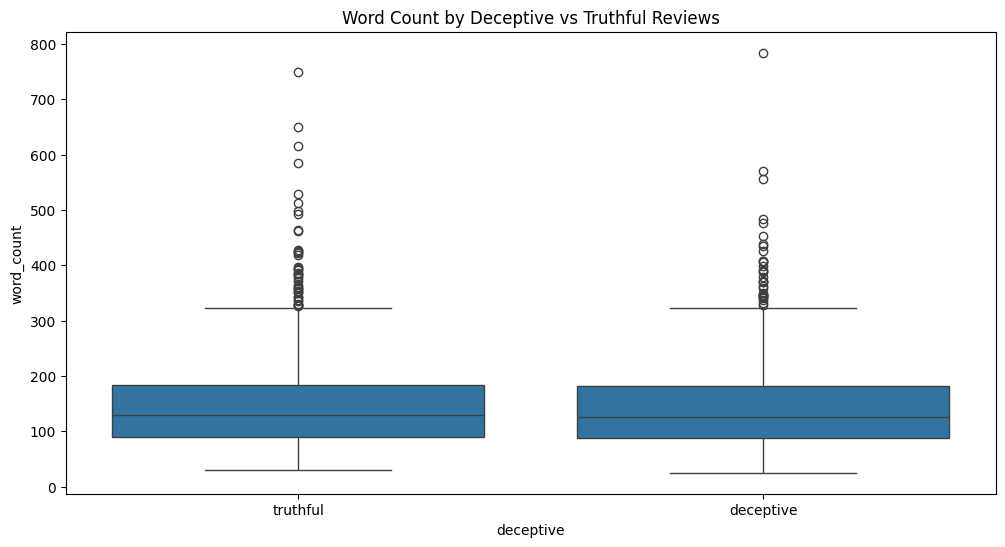

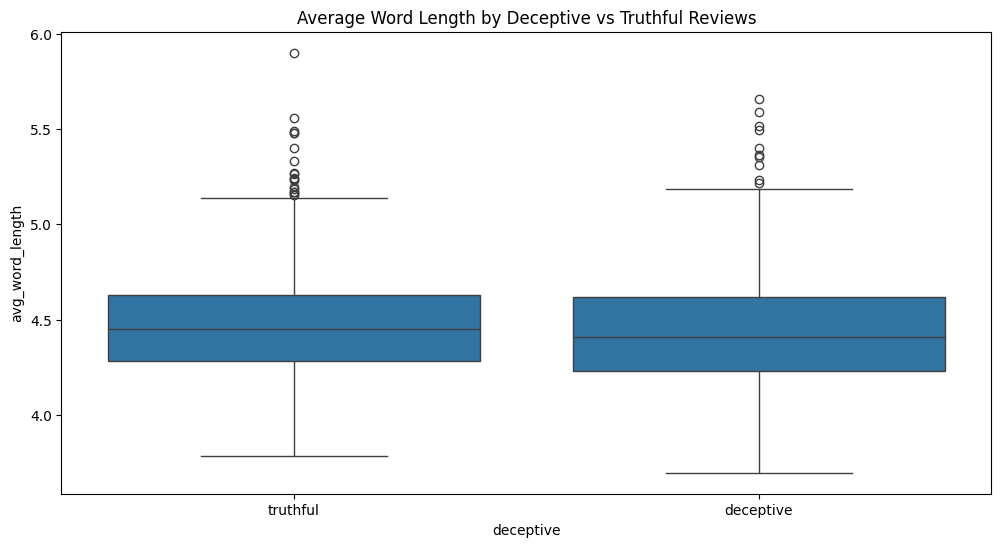

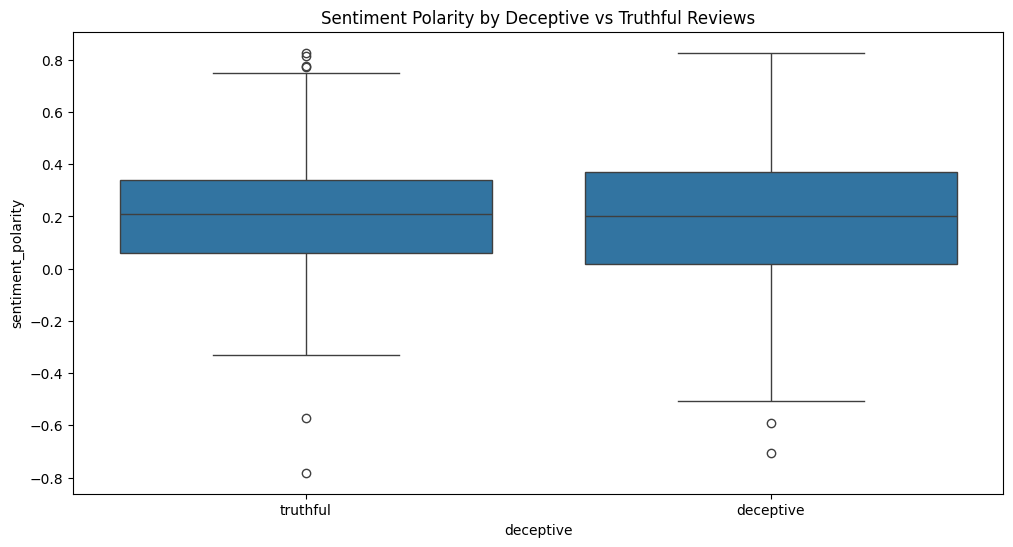

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       233
           1       0.54      0.50      0.52       247

    accuracy                           0.53       480
   macro avg       0.53      0.53      0.53       480
weighted avg       0.53      0.53      0.53       480


Confusion Matrix:
[[129 104]
 [123 124]]

Feature Importance:
              Feature  Importance
2  sentiment_polarity    0.351339
1     avg_word_length    0.332674
0          word_count    0.315987


In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Fill missing values
hotel_reviews['ReviewText'] = hotel_reviews['ReviewText'].fillna("")

# Step 1: Extract Linguistic Features
# Feature 1: Word Count
hotel_reviews['word_count'] = hotel_reviews['ReviewText'].apply(lambda x: len(x.split()))

# Feature 2: Average Word Length
hotel_reviews['avg_word_length'] = hotel_reviews['ReviewText'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
)

# Feature 3: Sentiment Polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

hotel_reviews['sentiment_polarity'] = hotel_reviews['ReviewText'].apply(get_sentiment)

# Step 2: Visualize Patterns
# Compare distributions of linguistic features between truthful and deceptive reviews
plt.figure(figsize=(12, 6))
sns.boxplot(x='deceptive', y='word_count', data=hotel_reviews)
plt.title("Word Count by Deceptive vs Truthful Reviews")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='deceptive', y='avg_word_length', data=hotel_reviews)
plt.title("Average Word Length by Deceptive vs Truthful Reviews")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='deceptive', y='sentiment_polarity', data=hotel_reviews)
plt.title("Sentiment Polarity by Deceptive vs Truthful Reviews")
plt.show()

# Step 3: Build a Classification Model
# Prepare the dataset
features = ['word_count', 'avg_word_length', 'sentiment_polarity']
X = hotel_reviews[features]
y = hotel_reviews['deceptive'].apply(lambda x: 1 if x == 'deceptive' else 0)  # Encode target as 1 for deceptive, 0 for truthful

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 4: Feature Importance
# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)
